# **Classical memory and model-based recommendation systems**

Сначала мы опробуем подход memory-based в модификации item-based, а затем SVD. Результаты применения обоих алгоритмов мы сможем сравнить с помощью метрики RMSE.

Для создания алгоритмов рекомендательной системы будем использовать библиотеку [surprise](https://surpriselib.com/).

Для обучения моделей возьмём датасет [movielens](https://lms-cdn.skillfactory.ru/assets/courseware/v1/6e47046882bad158b0efbb84cd5cb987/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/u.data.txt), который содержит информацию о фильмах и выставленных рейтингах с сайта https://movielens.org/.

## Загрузка инструментов и данных

In [1]:
import random
import pandas as pd
from surprise import Dataset
from surprise import Reader
from surprise import model_selection
from surprise.dataset import BUILTIN_DATASETS #с помощью данного объекта мы можем использовать встроенные датасеты
from surprise import SVD, KNNBasic, accuracy

import matplotlib.pyplot as plt

movielens_data = Dataset.load_from_file(
    "data/u.data.txt",
    reader=Reader(line_format="user item rating timestamp", sep="\t", rating_scale=(0, 5)),
)

# Преобразуем данные к формату pandas DataFrame для удобной работы с ними
movielens_df = pd.DataFrame(movielens_data.raw_ratings, columns=['userId', 'movieId', 'rating', 'timestamp'])

movielens_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100000 non-null  object 
 1   movieId    100000 non-null  object 
 2   rating     100000 non-null  float64
 3   timestamp  100000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 3.1+ MB


## Анализ данных

В данных присутствуют следующие признаки:
* `userId` — идентификаторы пользователей сайта movielens;
* `movieId` — идентификаторы фильмов;
* `rating` — оценки фильмов, выставленные пользователями по шкале от 1 до 5;
* `timestamp` — время оценки фильма пользователем. Данный формат представления времени показывает, сколько секунд прошло с 1 января 1970 года.

In [2]:
print('movielens data shape:', movielens_df.shape)
movielens_df.head()

movielens data shape: (100000, 4)


,userId,movieId,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


Посмотрим на число уникальных фильмов в наборе данных и аналогично — сколько уникальных пользователей.

In [3]:
print('Число уникальных фильмов:', movielens_df.movieId.nunique())
print('Число уникальных пользователей:', movielens_df.userId.nunique())

Число уникальных фильмов: 1682
Число уникальных пользователей: 943


А распределение оценок можно отобразить графически.

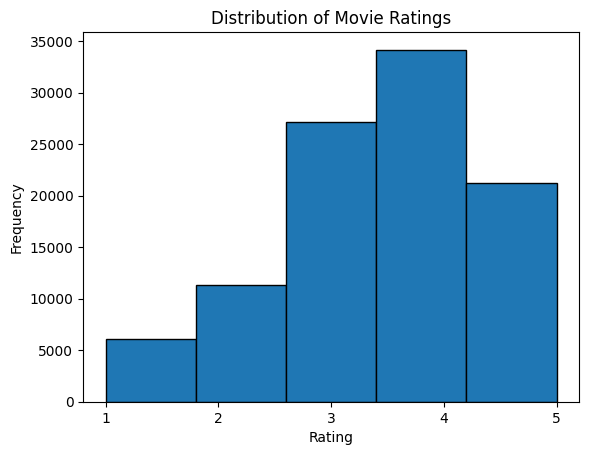

In [4]:
plt.hist(movielens_df.rating, bins=5, edgecolor='black')
plt.xlabel('Rating')
plt.xticks(range(1, 6))
plt.ylabel('Frequency')
plt.title('Distribution of Movie Ratings')
plt.show()

## Моделирование

Библиотека surprise очень похожа на библиотеку sklearn, и тоже позволяет разбить данные на обучающую и тестовую выборки всего одной функцией — [surprise.model_selection.train_test_split()](https://surprise.readthedocs.io/en/stable/getting_started.html#train-test-split-and-the-fit-method).

### Сэмплирование данных

Разобъём данные на обучающую и тестовую выборки.<br>Объём тестовой выборки составит 25 % от общего объёма данных.<br>В качестве значения параметра random_state по традиции возьмём 42.

In [5]:
trainset, testset = model_selection.train_test_split(
    movielens_data, test_size=0.25, random_state=42
    )
print('Testset len:', len(testset))

Testset len: 25000


### Item-memory-based model

Импортируем функции для построения рекомендательных систем (SVD — для model-based-подхода и KNNBasic — для memory-basic-подхода) и для оценки качества результата.

Реализуем обычную коллаборативную фильтрацию. Выберем оценку схожести через косинусную близость и item-based-подход:

In [6]:
# Настройка параметров
sim_options = {
    'name': 'cosine',
    'user_based': False
}

# Инициализация
knn = KNNBasic(sim_options=sim_options)

# Обучим алгоритм
knn.fit(trainset)

# Получение рекомендаций
predictions = knn.test(testset)
predictions[:10]

Computing the cosine similarity matrix...
Done computing similarity matrix.


[Prediction(uid='391', iid='591', r_ui=4.0, est=3.8010554567440296, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='181', iid='1291', r_ui=1.0, est=1.575, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='637', iid='268', r_ui=2.0, est=2.578661267671375, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='332', iid='451', r_ui=5.0, est=4.218539848773929, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='271', iid='204', r_ui=4.0, est=3.8747323580353688, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='27', iid='286', r_ui=3.0, est=3.3467792803165364, details={'actual_k': 15, 'was_impossible': False}),
 Prediction(uid='387', iid='663', r_ui=4.0, est=3.573894935783497, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='92', iid='722', r_ui=3.0, est=3.1032111131745377, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='820', iid='347', r_ui=4.0, est=3.1463649

Информация о каждой паре содержит следующие характеристики:
* uid — id пользователя;
* iid — id элемента;
* r_ui (float) — реальный рейтинг, который этот пользователь поставил этому элементу;
* est (float) — предсказанный рейтинг.

Для примера сравним реальный и прогнозируемый рейтинги случайно выбранной пары пользователь-фильм.

In [7]:
random_pair = random.choice(predictions)

uid = str(random_pair[0])
iid = str(random_pair[1])  

for prediction in predictions:
    if prediction.uid == uid and prediction.iid == iid:
        print(prediction.r_ui)
        print(round(prediction.est, 2))
        break

pred = knn.predict(uid, iid, verbose=True)

4.0
3.75
user: 64         item: 154        r_ui = None   est = 3.75   {'actual_k': 40, 'was_impossible': False}


Теперь необходимо вычислить RMSE для получившихся предсказаний:

In [8]:
accuracy.rmse(predictions);

RMSE: 1.0321


Итак, мы построили систему рекомендаций и даже оценили её качество. Но как же вывести рекомендации для конкретного пользователя?

Для начала давайте оформим наши предсказания в таблицу и отсортируем их по прогнозируемому рейтингу:

In [9]:
pred = pd.DataFrame(predictions)
pred.sort_values(by=['est'], inplace=True, ascending = False)

pred[:5]

,uid,iid,r_ui,est,details
5823,118,188,5.0,4.924250,"{'actual_k': 40, 'was_impossible': False}"
6022,118,7,5.0,4.900015,"{'actual_k': 40, 'was_impossible': False}"
8763,118,433,5.0,4.899095,"{'actual_k': 40, 'was_impossible': False}"
2405,118,193,5.0,4.876870,"{'actual_k': 40, 'was_impossible': False}"
13251,118,180,5.0,4.875483,"{'actual_k': 40, 'was_impossible': False}"


Теперь мы можем вывести рекомендуемые для конкретного пользователя фильмы, начиная от наиболее релевантного (с точки зрения рекомендаций) и заканчивая наименее релевантным.

In [10]:
random_uid = random.choice(list(pred.uid.values))
print('random uid:', random_uid)

recom = pred[pred.uid == random_uid]['iid'].to_list()

print('10 recommended movie ids:', recom[:10])

random uid: 73
10 recommended movie ids: ['475', '269', '179', '48', '357', '197', '59', '28', '135', '480']


### User-memory-based model

Реализуем теперь *user-based*-алгоритм.

In [11]:
sim_options = {
    'name': 'cosine'
}

# Инициализация
knn = KNNBasic(sim_options=sim_options)

# Обучим алгоритм
knn.fit(trainset)

# Получение рекомендаций
predictions = knn.test(testset)

# Расчет метрики
accuracy.rmse(predictions);

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0223


Ошибка стала незначительно меньше.

### SVD model

Теперь давайте сравним полученные результаты с результатами SVD-алгоритма.<br>Реализуем SVD с параметрами по умолчанию.

In [12]:
model = SVD()
model.fit(trainset)
predictions = model.test(testset)
accuracy.rmse(predictions);

RMSE: 0.9434


Ошибка стала ещё меньше — SVD вышел победителем.

In [13]:
predictions[:10]

[Prediction(uid='391', iid='591', r_ui=4.0, est=3.579327234974192, details={'was_impossible': False}),
 Prediction(uid='181', iid='1291', r_ui=1.0, est=1.4495534558376943, details={'was_impossible': False}),
 Prediction(uid='637', iid='268', r_ui=2.0, est=2.8757614680238137, details={'was_impossible': False}),
 Prediction(uid='332', iid='451', r_ui=5.0, est=3.8273325699944802, details={'was_impossible': False}),
 Prediction(uid='271', iid='204', r_ui=4.0, est=3.4533584603267515, details={'was_impossible': False}),
 Prediction(uid='27', iid='286', r_ui=3.0, est=3.3610375034580673, details={'was_impossible': False}),
 Prediction(uid='387', iid='663', r_ui=4.0, est=4.431833194640713, details={'was_impossible': False}),
 Prediction(uid='92', iid='722', r_ui=3.0, est=2.745482981549118, details={'was_impossible': False}),
 Prediction(uid='820', iid='347', r_ui=4.0, est=3.6613960220876374, details={'was_impossible': False}),
 Prediction(uid='479', iid='1444', r_ui=1.0, est=2.809987555154942, 